# Import Libraries

In [1]:
import re
import nltk 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import csv
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import  precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix

# Reading DataSet

In [2]:
df=pd.read_csv("data_clean_final.csv")
print(df.isnull().sum())
print(df.shape)
df.head()

Reviews    0
dtype: int64
(3979, 1)


,Reviews
0,upgrade the app
1,notification sound not working samsung
2,dunno why doalways error whensign
3,will not open
4,wants access everything talk about spy webb su...


# Data Cleaning

In [3]:
features=df.iloc[:,0].values
features

array(['upgrade the app', 'notification sound not working samsung',
       'dunno why doalways error whensign', ...,
       'used zoom for conferencing with our teams while working outages maintenance windows',
       'zoom well suited for organizations that vary all different sizes easily providing streamlined meeting capabilities for users any level iteasier imagine many different scenarios where zoom would work great rather than situations where would not appropriate that being said zoom best suited for organizations that appreciate video capabilities for their meetings',
       'zoom well suited cloud video meetings far better experience that current competitors zoom makes easy start joinmeeting from any device'],
      dtype=object)

In [20]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    #Search for all non-letters Replace all non-letters with spaces
    processed_feature = re.sub("[^a-zA-Z]"," ", str(processed_feature))
    
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    processed_feature=shortword.sub('', processed_feature)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)
    
df = pd.DataFrame(data=processed_features)
df.to_csv('clean_data_2.csv', index=None, header=True)
df

,0
0,upgrade the app
1,notification sound not working samsung
2,dunno why doalways error whensign
3,will not open
4,wants access everything talk about spy webb su...
...,...
3974,whenever have carry out follow meetings with c...
3975,zoom makes easy generate meetings and send the...
3976,used zoom for conferencing with our teams whil...
3977,zoom well suited for organizations that vary a...


# Sentiment Analysis
Finding Polarity of data & assigning Labels

In [21]:
infile = 'clean_data_2.csv'
bloblist = list()

with open(infile, 'r',encoding='utf-8') as csvfile:
    rows = csv.reader(csvfile)

    for row in rows:
        sentence = row[0]
        blob = TextBlob(sentence)
        bloblist.append((sentence,blob.sentiment.polarity, blob.sentiment.subjectivity))
    
df = pd.DataFrame(bloblist, columns = ['Reviews','polarity','subjectivity'])
#conditions  = [ df['polarity'] >=0.6, (df['polarity'] <0.6) & (df['polarity'] >0),df['polarity'] ==0,df['polarity'] < 0]
conditions  = [ df['polarity'] > 0,df['polarity'] == 0,df['polarity'] < 0]
choices     = [ "positive",'neutral','negative']

df["label"] = np.select(conditions, choices, default=np.nan)
df.to_csv('reviews_data_labelled.csv', index=None, header=True)

In [22]:
df=df.drop([0],axis=0)
df

,Reviews,polarity,subjectivity,label
1,upgrade the app,0.000000,0.000000,neutral
2,notification sound not working samsung,0.400000,0.400000,positive
3,dunno why doalways error whensign,0.000000,0.000000,neutral
4,will not open,0.000000,0.500000,neutral
5,wants access everything talk about spy webb su...,0.233333,0.662963,positive
...,...,...,...,...
3975,whenever have carry out follow meetings with c...,0.100000,0.332143,positive
3976,zoom makes easy generate meetings and send the...,0.433333,0.833333,positive
3977,used zoom for conferencing with our teams whil...,0.000000,0.000000,neutral
3978,zoom well suited for organizations that vary a...,0.354762,0.583333,positive


# Data Division

Shape of Data:  (3979, 4)


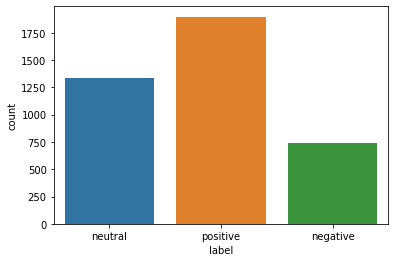

In [23]:
print("Shape of Data: ",df.shape)
sns.countplot(df['label'])
plt.show()

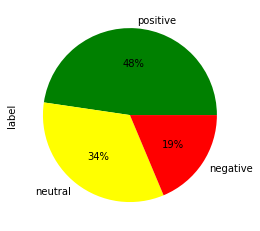

In [24]:
df.label.value_counts().plot(kind="pie", autopct='%1.0f%%', colors=["green", "yellow","red"])

In [25]:
Y_label=df.iloc[:,3].values
target_names=['Positive', 'Negative', 'Neutral']
labels=df['label']
X_features=np.array(processed_features)
print(X_features.shape)
print(Y_label.shape)


(3979,)
(3979,)


# Splitting Data Set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_features, Y_label, test_size=0.3)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(X_train)

(2785,)
(1194,)
['was different'
 'plz make this app work onsplit screen thencan online classes and read other stuff while still looking see howlook others'
 'fantastic appwould like know the maximum number video calls forsuit and ordinary google accounts'
 ... 'have yet learn more but will try wasgood experience'
 'this app awesome but has some issues with the audio gets automatically red green and sometimes white plz something about'
 'really enjoy using google classroom get information out students quickly homebase for all websites information assessments files you name students know there for links everything']


# Applying TFIDF

In [31]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train=tfidf_vectorizer.fit_transform(X_train).toarray()
tfidf_test=tfidf_vectorizer.transform(X_test).toarray()
print(tfidf_train.shape)
print(tfidf_test.shape)

(2785, 6140)
(1194, 6140)


In [32]:
print(tfidf_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Applying SVM

In [ ]:
svm = SVC()
svm.fit(tfidf_train, y_train)

In [16]:
svm_pred=svm.predict(tfidf_test)

accSVM = accuracy_score(y_test,svm_pred)
accSVM=round(accSVM*100,2)
print(f'Accuracy of SVM : {accSVM}%')

Accuracy of SVM : 76.72%


 A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric.

In [17]:
confusion = confusion_matrix(y_test, svm_pred)
print('Confusion Matrix\n')
print(confusion)

print('Micro Precision: {:.2f}'.format(precision_score(y_test, svm_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, svm_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, svm_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, svm_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, svm_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, svm_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, svm_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, svm_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, svm_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, svm_pred))

Confusion Matrix

[[ 78  74  58]
 [  3 325  51]
 [  7  85 513]]
Micro Precision: 0.77
Micro Recall: 0.77
Micro F1-score: 0.77

Macro Precision: 0.79
Macro Recall: 0.69
Macro F1-score: 0.70

Weighted Precision: 0.79
Weighted Recall: 0.77
Weighted F1-score: 0.75

Classification Report

              precision    recall  f1-score   support

    negative       0.89      0.37      0.52       210
     neutral       0.67      0.86      0.75       379
    positive       0.82      0.85      0.84       605

    accuracy                           0.77      1194
   macro avg       0.79      0.69      0.70      1194
weighted avg       0.79      0.77      0.75      1194



# Applying Multinomial Naive Byes

In [18]:
NaiveByes = MultinomialNB() 
NaiveByes.fit(tfidf_train, y_train) 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
pred_NB = NaiveByes.predict(tfidf_test) 

accuracy_NB = metrics.accuracy_score(y_test, pred_NB)
accuracy_NB=round(accuracy_NB*100,2)
print(f'Accuracy of Naive Byes Model : {accuracy_NB}%')

Accuracy of Naive Byes Model : 61.73%


In [20]:
confusion = confusion_matrix(y_test, pred_NB)
print('Confusion Matrix\n')
print(confusion)

print('Micro Precision: {:.2f}'.format(precision_score(y_test, pred_NB, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, pred_NB, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred_NB, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, pred_NB, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, pred_NB, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, pred_NB, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, pred_NB, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, pred_NB, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, pred_NB, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, pred_NB))

Confusion Matrix

[[ 38  18 154]
 [  1 106 272]
 [  1  11 593]]
Micro Precision: 0.62
Micro Recall: 0.62
Micro F1-score: 0.62

Macro Precision: 0.77
Macro Recall: 0.48
Macro F1-score: 0.48

Weighted Precision: 0.71
Weighted Recall: 0.62
Weighted F1-score: 0.55

Classification Report

              precision    recall  f1-score   support

    negative       0.95      0.18      0.30       210
     neutral       0.79      0.28      0.41       379
    positive       0.58      0.98      0.73       605

    accuracy                           0.62      1194
   macro avg       0.77      0.48      0.48      1194
weighted avg       0.71      0.62      0.55      1194



# Applying Passive Aggressive Classifier

In [21]:
PA_Model=PassiveAggressiveClassifier()
PA_Model.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

In [22]:
pred_PA=PA_Model.predict(tfidf_test)

accuracy_PA=accuracy_score(y_test,pred_PA)
accuracy_PA=round(accuracy_PA*100,2)
print(f'Accuracy of Passive Aggressive Model : {accuracy_PA}%')

Accuracy of Passive Aggressive Model : 77.72%


In [23]:
confusion = confusion_matrix(y_test, pred_PA)
print('Confusion Matrix\n')
print(confusion)

print('Micro Precision: {:.2f}'.format(precision_score(y_test, pred_PA, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, pred_PA, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred_PA, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, pred_PA, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, pred_PA, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, pred_PA, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, pred_PA, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, pred_PA, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, pred_PA, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, pred_PA))

Confusion Matrix

[[124  53  33]
 [ 19 310  50]
 [ 35  76 494]]
Micro Precision: 0.78
Micro Recall: 0.78
Micro F1-score: 0.78

Macro Precision: 0.75
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.78
Weighted Recall: 0.78
Weighted F1-score: 0.78

Classification Report

              precision    recall  f1-score   support

    negative       0.70      0.59      0.64       210
     neutral       0.71      0.82      0.76       379
    positive       0.86      0.82      0.84       605

    accuracy                           0.78      1194
   macro avg       0.75      0.74      0.74      1194
weighted avg       0.78      0.78      0.78      1194



# Applying Decision Tree

In [24]:
model_Tree=tree.DecisionTreeClassifier(criterion="entropy")
model_Tree.fit(tfidf_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [25]:
DT_predict=model_Tree.predict(tfidf_test)

acc_DT=accuracy_score(y_test,DT_predict)
acc_DT=round(acc_DT*100,2)
print(f'Accuracy of Decision Tree : {acc_DT}%')

Accuracy of Decision Tree : 77.14%


In [26]:
confusion = confusion_matrix(y_test, DT_predict)
print('Confusion Matrix\n')
print(confusion)

print('Micro Precision: {:.2f}'.format(precision_score(y_test, DT_predict, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, DT_predict, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, DT_predict, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, DT_predict, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, DT_predict, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, DT_predict, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, DT_predict, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, DT_predict, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, DT_predict, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, DT_predict))

Confusion Matrix

[[101  66  43]
 [ 16 334  29]
 [ 45  74 486]]
Micro Precision: 0.77
Micro Recall: 0.77
Micro F1-score: 0.77

Macro Precision: 0.73
Macro Recall: 0.72
Macro F1-score: 0.72

Weighted Precision: 0.77
Weighted Recall: 0.77
Weighted F1-score: 0.77

Classification Report

              precision    recall  f1-score   support

    negative       0.62      0.48      0.54       210
     neutral       0.70      0.88      0.78       379
    positive       0.87      0.80      0.84       605

    accuracy                           0.77      1194
   macro avg       0.73      0.72      0.72      1194
weighted avg       0.77      0.77      0.77      1194



# Applying Random Forest

In [27]:
text_classifier_RF = RandomForestClassifier()
text_classifier_RF.fit(tfidf_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
predictions_RF= text_classifier_RF.predict(tfidf_test)
accuracy_RF=accuracy_score(y_test,predictions_RF)
accuracy_RF=round(accuracy_RF*100,2)
print(f'Accuracy of RF Model : {accuracy_RF}%')

confusion = confusion_matrix(y_test, predictions_RF)
print('Confusion Matrix\n')
print(confusion)

print('Micro Precision: {:.2f}'.format(precision_score(y_test, predictions_RF, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, predictions_RF, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, predictions_RF, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, predictions_RF, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, predictions_RF, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, predictions_RF, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, predictions_RF, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, predictions_RF, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, predictions_RF, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, predictions_RF))

Accuracy of RF Model : 80.07%
Confusion Matrix

[[101  69  40]
 [  3 357  19]
 [ 18  89 498]]
Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80

Macro Precision: 0.81
Macro Recall: 0.75
Macro F1-score: 0.75

Weighted Precision: 0.82
Weighted Recall: 0.80
Weighted F1-score: 0.79

Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.48      0.61       210
     neutral       0.69      0.94      0.80       379
    positive       0.89      0.82      0.86       605

    accuracy                           0.80      1194
   macro avg       0.81      0.75      0.75      1194
weighted avg       0.82      0.80      0.79      1194



# Comparing Accuracy

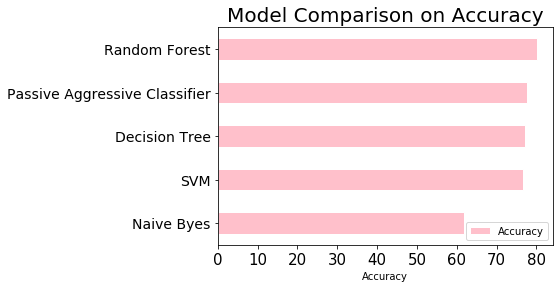

In [29]:
model_comparison = pd.DataFrame({'ML_Models': ['Passive Aggressive Classifier', 'Naive Byes', 'Decision Tree',
                                             'Random Forest','SVM'],
                                 'Accuracy': [accuracy_PA, accuracy_NB,  
                                         acc_DT,accuracy_RF,accSVM]})

model_comparison.sort_values('Accuracy', ascending = True).plot(x = 'ML_Models', y = 'Accuracy', kind = 'barh',
                                                           color = 'pink', edgecolor = 'white')


plt.ylabel('');
plt.yticks(size = 14);
plt.xlabel('Accuracy');
plt.xticks(size = 15)
plt.title('Model Comparison on Accuracy', size = 20);